# Calibration (SEAI5R model)
Using generated data, we test if we can infer that a lockdown has happened and how the contact parameters have changed.
To do this, we generate a test trajectory with a lockdown at time $20$. 
The lockdown is implemented by scaling the contact matrices (for work, school, other).
We use the data points up to the lockdown to infer the parameters of the SEAI5R model.
Using the data after lockdown and the inferred parameters, we infer the change of the contact structure.

For the pre-intervention period, we infer the following parameters: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), 
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals), 
* $\gamma_\mathrm{E}$ (rate of exposed -> activated), 
* $\gamma_\mathrm{A}$ (rate of activated -> infected, symptomatic or asymptomatic)

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory

In [3]:
# population and age classes (4 age groups, UK contact structure)
M = 4  # number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF  = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N = np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]

for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]

# Make the numbers a bit smaller to speed up the simluations
Ni = np.array(Ni / 5e2, dtype=np.int)
N = sum(Ni)

In [4]:
# Generate class with contact matrix for SIR-type model with UK contact structure
generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)

T_intervention = 20
times= [T_intervention] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.4, 0.4, 0.4

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [5]:
beta  = 0.04         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of symptomatic infectives    
gIh   = 1/14         # recovery rate of hospitalised infectives
gIc   = 1/14         # recovery rate of intensive care (IC) infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter
fh    = 0.1 
gE    = 1/5          # rate of exposed to activated
gA    = 1/3          # rate of activated to infected

hh = 0.1*np.ones(M)      # fraction which goes from Is to hospital
cc = 0.05*np.ones(M)     # fraction which goes from  hospital to ICU 
mm = 0.4*np.ones(M)      # mortality from IC
sa = 0  # change in the population, not taken into account by inference at the moment 


# initial conditions
E0   = np.array([10]*M)
A0   = np.array([10]*M)
Ia0  = np.array([10]*M)  # each age group has asymptomatic infectives
Is0  = np.array([10]*M)  # and also symptomatic infectives
Ih0  = np.array([10]*M)
Ic0  = np.array([10]*M)
Im0  = np.array([2]*M)
R0   = np.zeros(M)
S0   = Ni - (Ia0+Is0+R0+E0+A0+Ih0+Ic0+Im0)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs, 'gIh':gIh,'gIc':gIc, 
              'gE':gE, 'gA':gA, 'fsa':fsa, 'fh':fh, 'sa':sa, 'hh':hh, 'cc':cc,
              'mm':mm}
true_parameters = parameters
model = pyross.stochastic.SEAI5R(parameters, M, Ni)
print(Ni)

# start simulation
Tf = 100
Nf = Tf+1 
data = model.simulate(S0, E0, A0, Ia0, Is0, Ih0, Ic0, Im0, C, Tf, Nf)

[31268 35668 35526 25759]


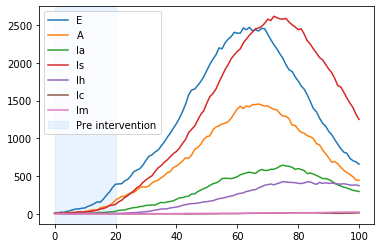

In [6]:
# plot the stochastic solution 
plt.plot(data['X'][:, M], label='E')
plt.plot(data['X'][:, 2*M], label='A')
plt.plot(data['X'][:, 3*M], label='Ia')
plt.plot(data['X'][:, 4*M], label='Is')
plt.plot(data['X'][:, 5*M], label='Ih')
plt.plot(data['X'][:, 6*M], label='Ic')
plt.plot(data['X'][:, 7*M], label='Im')
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.1, color='dodgerblue')
plt.legend()
plt.show()

## 2) Infer the parameters of the model

-6319.377533633682
12.735768795013428


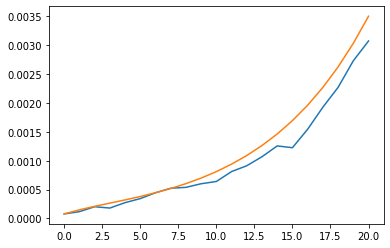

In [7]:
Tf = 20 # truncate to only getting the first few datapoints (up to lockdown)
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf,:8*M]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, generator.constant_CM)
end_time = time.time()
print(logp) 
print(end_time - start_time)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditons 
# They are likely to be different due to the inherent stochasticity of the model 
Tf_initial = T_intervention # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1
contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SEAI5R(parameters, int(M), fi)
estimator = pyross.inference.SEAI5R(parameters, M, fi, int(N), steps)
xm = estimator.integrate(x[0], 0, Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, x[:, M])
plt.plot(t, xm[:, M])
plt.show()

In [ ]:
# take a guess
alpha_g = 0.25
alpha_std = 0.2 
alpha_b = (0.1,0.5)

beta_g = 0.03
beta_std = 0.1 
beta_b = (1e-3, 1)

gIa_g = 0.15  
gIa_std = 0.05 
gIa_b = (0.01, 1)

gIs_g = 0.13 
gIs_std = 0.05 
gIs_b = (0.01, 1)

gE_g = 0.2
gE_std = 0.05 
gE_b = (0.01, 1)

gA_g = 0.3 
gA_std = 0.1 
gA_b = (0.01, 1) 

# optimisation parameters 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
ftol = 1e-5 # the relative tol in (-logp)  

# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
# stds of the model parameters' priors
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std])

# make an initial guess and do inference 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g])
params = estimator.inference(guess, stds, x, Tf, Nf, generator.constant_CM, bounds=bounds, 
                             verbose=True, global_max_iter=5, global_ftol_factor=1e3, 
                             ftol=ftol, eps=eps)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=3494140995, Mon May 18 10:22:30 2020)


In [ ]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(estimator.make_params_dict(params))

In [ ]:
## calculate hessian
hess = estimator.hessian(params, guess, stds, x, Tf, Nf, generator.constant_CM)

In [ ]:
np.linalg.cholesky(hess) #if error is thrown, it is not positive definite 

## 3) Infer the change of contact structure 

In [ ]:
## guesses and bounds for control parameters
aW_g = 0.5 
aW_std = 0.2
aW_bounds = [0.2, 0.8]

aS_g = 0.5
aS_std = 0.2 
aS_bounds = [0.2, 0.8]

aO_g = 0.4
aO_std = 0.1
aO_bounds = [0.2, 0.8]

guess = np.array([aW_g, aS_g, aO_g])
stds = np.array([aW_std, aS_std, aO_std])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = data['X']/N
x = x[21:61, :8*M]  # Only take the first 30 values after lockdown
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp)
# x = (np.load('post_intervention_SEAI5R_traj.npy')[:, :8*M])/N 
# cut the trajectory 
# Tf_control = 30 
# Nf_control = Tf_control+1 
# x = x[:Nf_control]

In [ ]:
eps = 1e-3
ftol = 1e-5 
start_time = time.time() 
params_control  = estimator.infer_control(guess, stds, x, Tf, Nf, generator, bounds,
                                          global_max_iter=5, global_ftol_factor=1e4, verbose=True, 
                                          ftol=ftol, eps=eps)

# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params_control) # best guess 
print(end_time - start_time)

In [ ]:
print("True lockdown factors:")
print([aW, aS, aO])

print("\nInferred lockdown factors:")
print(params_control)

In [ ]:
times = [T_intervention]

x = data['X']/N
x_pre = x[:T_intervention]
x_post = x[T_intervention:]

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters)

inferred_interventions = [[1.0,1.0,1.0],      # before first time
                 params_control,       # after first time
                ]         

print(params_control)
no_interventions = [[1.0,1.0,1.0],[1.0,1.0,1.0],]

# compare the true trajectory with the 
contactMatrix_inter = generator.interventions_temporal(times=times,interventions=inferred_interventions)
contactMatrix_nointer = generator.interventions_temporal(times=times,interventions=no_interventions)

Tf=100;  Nf=Tf+1 


## create deterministic model
det_model = pyross.deterministic.SEAI5R(parameters, M, fi)

## integrate up with the inference on control and without
x_det_control = estimator.integrate(x_pre[0], 0, Tf, Nf, det_model, contactMatrix_inter)
x_det_control= np.asarray(x_det_control)

x_det_nocontrol = estimator.integrate(x_pre[0], 0, Tf, Nf, det_model, contactMatrix_nointer)
x_det_nocontrol= np.asarray(x_det_nocontrol)


### Plotting in particular style all the infected/exposed classes A, E, and all I classes
x = np.vstack((x_pre, x_post))
## Summing all infected classes
infected_tot = np.sum(x[:,1*M:7*M], axis=1)
infected_tot_control = np.sum(x_det_control[:,1*M:7*M], axis=1)
infected_tot_nocontrol = np.sum(x_det_nocontrol[:,1*M:7*M], axis=1)

## Plotting image
ylabel=r'Fraction of infectives'
fontsize=25
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, 20, 
           label='Before Intervention',
           alpha=0.3, color='dodgerblue')

ax.plot(infected_tot_control, label='with Control Inference')
ax.plot(infected_tot_nocontrol, label='without Control Inference')
ax.plot(infected_tot, '--r', label='Actual Model Infectives')

ax.set_xlim(0,Tf)
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.6,1),
          fontsize=15)
plt.show()
print(params_control)